In [2]:
import sys; sys.path.append('../../')
from definitions import *
from notebooks.nb_imports import *

In [3]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
from src.models.evaluators import ComputeNormalizedUtility

In [4]:
# Labels and the predictions for a 15 lookback window
labels = load_pickle(ROOT_DIR + '/data/processed/labels/original.pickle')
data = load_pickle(ROOT_DIR + '/data/interim/munged/df.pickle')
predictions = load_pickle(ROOT_DIR + '/models/experiments/basic_sig/1/predictions.pickle')

In [5]:
data.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'hospital', 'ShockIndex', 'BUN/CR',
       'HepaticSOFA', 'MEWS', 'qSOFA', 'SOFA', 'SOFA_deterioration',
       'SepticShock', 'SIRS', 'SIRS_path'],
      dtype='object')

# Sepsis score when predicting based purely on time
Here we see we can get resonable score performance when we predict purely based on time. The max occurs setting t=1 at around 52hrs

In [5]:
# Get the length of stay
los = data['ICULOS']

In [6]:
# Set a new col to 1 if LOS > T
preds = pd.Series(index=los.index, data=0)
preds[los > 60] = 1
preds = preds[los>60]

Max score: 0.283 at t=52


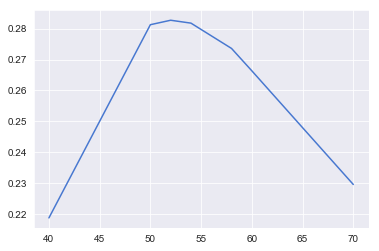

In [7]:
tt = [40, 50, 52, 54, 58, 60, 70]
scores = []
for t in tt:
    preds = pd.Series(index=los.index, data=0)
    preds[los > t] = 1
    score = ComputeNormalizedUtility().score(labels, preds)
    scores.append(score)
plt.plot(tt, scores)
print('Max score: {:.3f} at t={}'.format(max(scores), tt[np.argmax(scores)]))

# Sepsis score if only late times counted
We know that prediction of pure 1s at late times can get a resonable score, here we see what the score is if we just considered that segment.

> A score of 0.825 is achieved on the t > 58 section if we predict 1s for everything such that t > 58

Max score: 0.792 at t=70


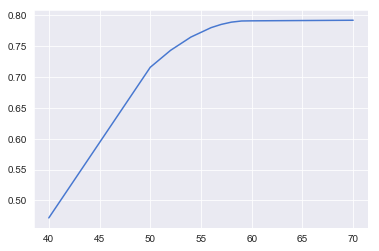

In [18]:
tt = [40, 50, 52, 54, 56, 57, 58, 59, 60, 70]
scores = []
for t in tt:
    preds = pd.Series(index=los.index, data=0)
    preds[los > t] = 1
    preds = preds[los > t]
    score = ComputeNormalizedUtility().score(labels.loc[preds.index], preds)
    scores.append(score)
plt.plot(tt, scores)
print('Max score: {:.3f} at t={}'.format(max(scores), tt[np.argmax(scores)]))

In [ ]:
scores

It thus makes sense that if we can improve prediction for t <= 58, then we will get an extremely high utility. But t < 58 is of course most of the data. 

# Predictions at t < 58

## Score to beat
Here we give the score we want to beat at t < 58 if we predict one for all t > 58

### Overall

In [11]:
preds = predictions.loc[pd.IndexSlice[:, :58]]
score = ComputeNormalizedUtility().score(labels.loc[preds.index], preds)
print('Score when looking at t < 58: {:.3f}'.format(score))

Score when looking at t < 58: 0.171


**The score is 0.171 for t < 58 if we just look at these early times at t < 58. If we can simply improve on this we will have a good method of classification.**

### If we look at each cumulative time separately
That is, what is the overall score if we consider data up to t.

> Worst scores occur between around 0 and 60

In [20]:
tt = range(1, 70, 5)
scores = pd.Series(index=tt)

for t in tt:
    p = predictions.loc[:, :t]
    score = ComputeNormalizedUtility().score(labels.loc[p.index], p)
    scores.loc[t] = score

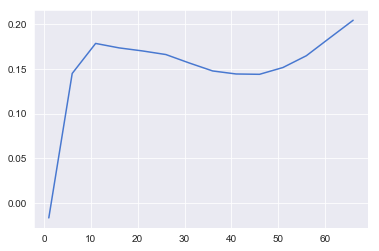

In [21]:
plt.plot(tt, scores)

**We should create new predictors in the 0 to 50 region that will hopefully not have time being so impactful.**

In [22]:
scores

1    -0.016610
6     0.144844
11    0.178404
16    0.173441
21    0.170028
26    0.166002
31    0.156555
36    0.147644
41    0.144267
46    0.143895
51    0.151477
56    0.164655
61    0.184564
66    0.204328
dtype: float64